# Supernova Example

## Introduction

In this toy example we compare ABC and MCMC as methods of estimating cosmological parameters from supernovae data.  The following model describes the distance modulus as a function of redshift:  

$$\mu_{i}^{model}(z_{i};\Omega_{m},w_{0}) \propto 5log_{10}(\frac{c(1+z)}{h_{0}})\int_{0}^{z}\frac{dz'}{E(z')}$$


$$E(z) = \sqrt{\Omega_{m} (1+z)^{3} + (1-\Omega_{m})e^{3\int_{0}^{z} dln(1+z')[1+w(z')]}}$$

Both ABC and MCMC use this model to estimate the posterior distributions of matter density $\Omega_{m}$ and the dark energy equation of state $w_{0}$.

To demonstrate the difference between ABC and MCMC, we first generate a dataset containing artificial noise such that the distribution of the data is non-Gaussian.  
* To use MCMC we are required to specify a likelihood function $\mathcal{L}(D|\Omega_{m}, w_{0})$.  By making the standard assumption of a Gaussian likelihood, we are (incorrectly) assumming that the data is Gaussian distributed. Under this assumption we expect biased results from MCMC.  
 
 
* To use ABC, we must be able to simulate the data at every point in parameter space.  The simulation can naturally include non-Gaussian noise (in many physical examples it is easier to include noise in a simulation then to account for it analytically).    










In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
import numpy as np
from scipy.stats import skewnorm
import math
import astroabc
from distance_calc import DistanceCalc   
from bin_data import *

## The Data

First, we need to provide a dataset.  The aim is to generate values of the distance modulus, $\mu_{i}$, with fixed "true" parameters $\Omega_{m}$ and $w_{0}$

$$\Omega_{m} = 0.3$$
$$w_{0} = -1.0$$

SNANA is used to generate ~400 supernova light curves which are then fit with the SALT-II light curve fitter. The  data span the redshift interval $z \in [0.5,1.0]$ and are binned into 20 redshift bins.

In [2]:

zbins,avmu_bin,averr_bin,mu_in_bin_new,mu_in_bin_new = read_data()

### Adding noise to the data

To add artificial noise to the data we use a skewed normal distribution.  The standard normal distribution has a probability distribution function given by

$$ \phi(x) = \frac{1}{\sqrt{2 \pi}} e^{-\frac{x^{2}}{2}}$$

and a cumulative distribution function: 

$$\Phi(x) = \frac{1}{2} [1 + erf(\frac{x}{\sqrt{2}})] $$

The skewed normal distribution $f(x)$ with parameter $\alpha$ is given by 

$$f(x) = 2\phi(x)\Phi(\alpha x)$$

Using this probability distribution function, we can draw a random sample from the skewed normal distribution.

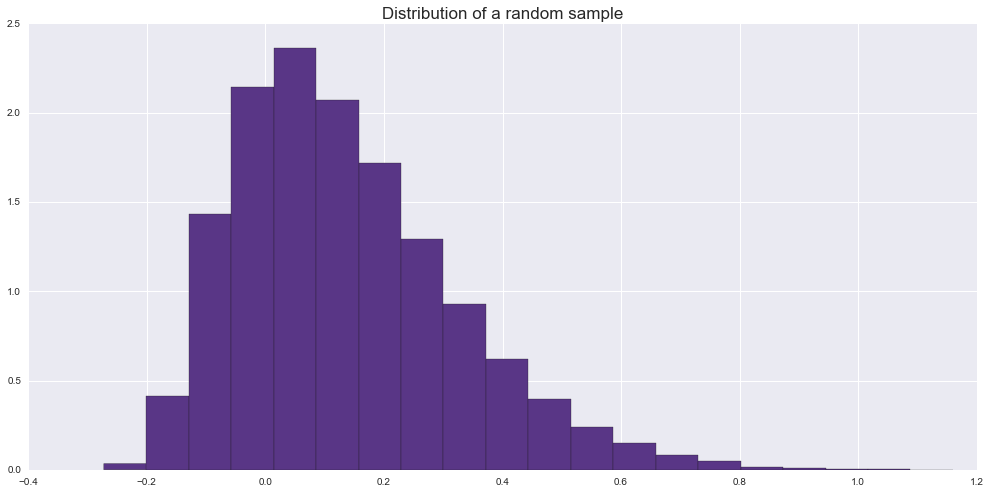

In [8]:
e = -0.1 #location
w = 0.3 #scale
a = 5.0 #skew

plt.figure(figsize=(17,8))
plt.hist(skewnorm.rvs(a, loc=e, scale=w, size=10000),normed=True,bins=20,color='#593686')
plt.title("Distribution of a random sample",fontsize=17);

From this distribution, the noisy data is generated.  At each $z_{i}$ a random number is drawn from the above distribution and added to $\mu_{i}$.  


In [9]:
data = np.zeros(len(zbins)) 

for i in range(len(zbins)):
    data[i] = avmu_bin[i] + skewnorm.rvs(a, loc=e, scale=w, size=1)

A comparison of the data before and after noise is added is shown below:

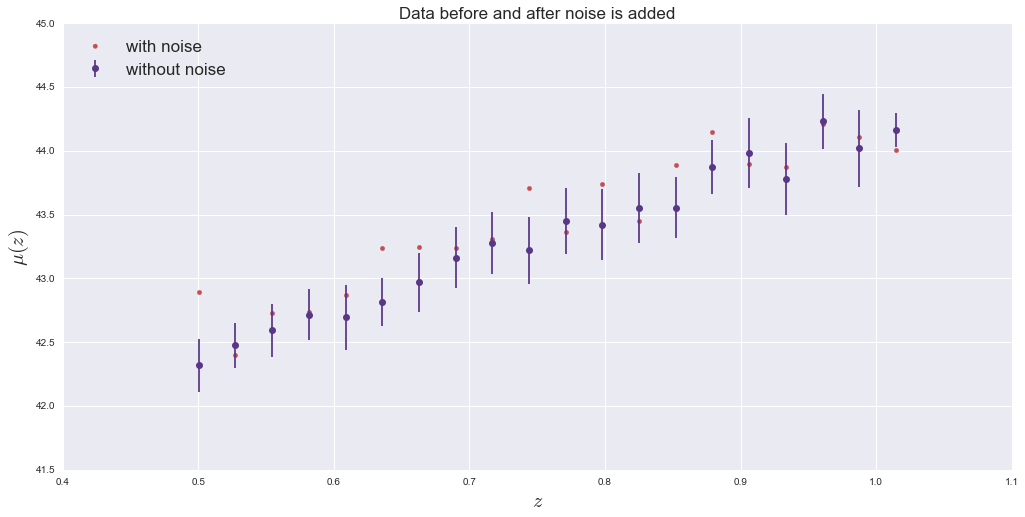

In [10]:
plt.figure(figsize=(17,8))
plt.errorbar(zbins,avmu_bin,averr_bin,marker="o",linestyle="None",label="without noise",color='#593686')
plt.scatter(zbins,data,color='r',label="with noise")
plt.legend(loc="upper left",prop={'size':17});
plt.xlabel("$z$",fontsize=20)
plt.ylabel("$\mu(z)$",fontsize=20)
plt.title("Data before and after noise is added",fontsize=17);

To demonstrate the non-Gaussian distribution of the data at each $z_{i}$, we focus on the data at $z_{1}=0.5$.  The distribution of a large random sample at this redshift is shown below.  Each value in this sample is generated by adding a randomly drawn number from the skewed normal distribution to $\mu_{1}$.  The value of $\mu_{1}$ before noise is added is shown in red. As we can see the data is now a skewed distribution around the expected mean.

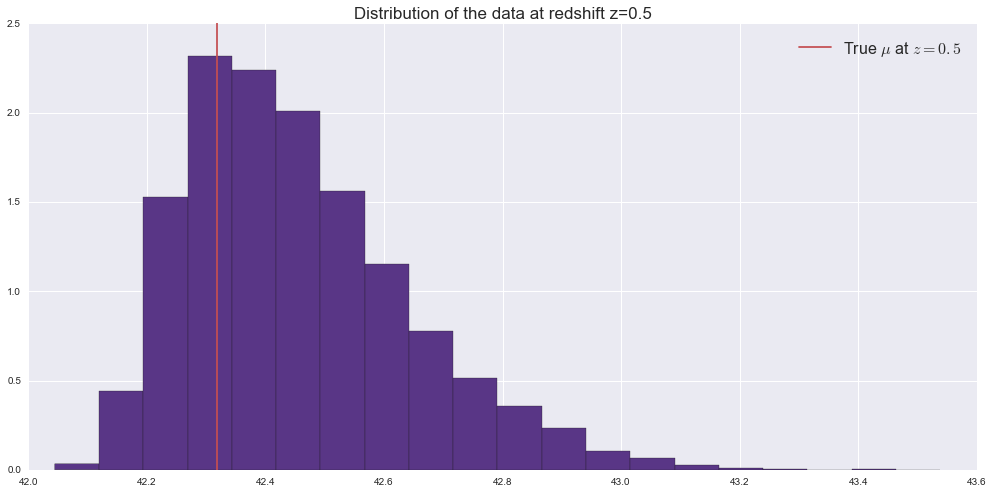

In [11]:
z = 0
distribution = np.zeros(10000)

for j in range(10000):
    distribution[j] = avmu_bin[z] + skewnorm.rvs(a, loc=e, scale=w, size=1)

plt.figure(figsize=(17,8))
plt.title("Distribution of the data at redshift z=0.5",fontsize=17);
plt.hist(distribution,bins=20,color='#593686',normed=True)
plt.plot((avmu_bin[z], avmu_bin[z]), (0, 2.5), 'r-', label="True $\mu$ at $z = 0.5$");
plt.legend(prop={'size':16});

## ABC

ABC is used to estimate the posterior distribution of the unknown parameters $\Omega_{m}$ and $w_{0}$ from the data.  To use ABC we need to specify:
* A metric $\rho$
* Prior distributions of $\Omega_{m}$ and $w_{0}$
* A simulation function


For more information on each of these, please see the [Introduction](https://github.com/EliseJ/astroABC/blob/master/examples/intro.ipynb) page or the simple [Gaussian]( http://localhost:8889/notebooks/multi-gaussian%20example.ipynb)  demo

In this example the metric $\rho$ is defined to be
$$\rho(\mu,\mu_{sim}(z)) = \sum_{i} \frac{(\mu_{i} - \mu_{sim}(z_{i}))^{2}}{2 \sigma_{i}^{2}}$$
where $\sigma_{i}$ is the error on the data point $\mu_{i}$.

In [56]:
def my_dist(d,x):
    if x[0]==None:
        return float('Inf')
    else:
        return np.sum(((x-d)/averr_bin)**2)          

Parameters needed for ABC are specified:


In [61]:
nparam = 2
npart = 100 #number of particles/walkers
niter = 20  #number of iterations
tlevels = [500.0,0.005] #maximum,minimum tolerance

prop={'tol_type':'exp',"verbose":1,'adapt_t':True,
      'threshold':75,'pert_kernel':2,'variance_method':0,
      'dist_type': 'user','dfunc':my_dist, 'restart':"restart_test.txt", \
      'outfile':"abc_pmc_output_"+str(nparam)+"param.txt",'mpi':False,
      'mp':True,'num_proc':2, 'from_restart':False}

The prior distributions of $\Omega_{m}$ and $w_{0}$ are chosen as follows:
* For $\Omega_{m}$ we use a normal distribution with mean $0.3$ and standard deviation $0.5$.
* For $w_{0}$ we use a normal distribution with mean $-1.0$ and standard deviation $0.5$.

In [62]:
priorname  = ["normal","normal"]
hyperp = [[0.3,0.5], [-1.0,0.5]]
prior = zip(priorname,hyperp)

Finally, we need a simulation function.  This must be able to simulate the data at every point in parameter space.  At each $z_{i}$ the simulation uses $\mu_{model}(z_{i};\Omega_{m},w_{0})$ given by
$$\mu_{i}^{model}(z_{i};\Omega_{m},w_{0}) \propto 5log_{10}(\frac{c(1+z)}{h_{0}})\int_{0}^{z}\frac{dz'}{E(z')}$$

to produce a value of distance modulus.  To account for noise in the data we then add a number randomly drawn from a skewed normal distribution.  

In [63]:
def ABCsimulation(param): #param = [om, w0] 
    if param[0] < 0.0 or param[0] > 1.0:
        return [None]*len(zbins)
    else:
        model_1_class = DistanceCalc(param[0],0,1-param[0],0,[param[1],0],0.7)  #om,ok,ol,wmodel,de_params,h0
        data_abc = np.zeros(len(zbins))
        for i in range(len(zbins)):
                data_abc[i] = model_1_class.mu(zbins[i]) + skewnorm.rvs(a, loc=e, scale=w, size=1)
        return data_abc


The ABC sampler is run for 20 iterations.  At each iteration the current estimate of the unknown parameters is shown.


In [64]:
sampler = astroabc.ABC_class(nparam,npart,data,tlevels,niter,prior,**prop)
sampler.sample(ABCsimulation)

	 	
	 ########################     astroABC     ########################	
	 	
	 Npart=100 	 numt=20 	 tol=[500.00,0.01] exp
	 Priors= [('normal', [0.3, 0.5]), ('normal', [-1.0, 0.5])]
	 Running sampler...	 
	 Step: 0 	 tol: 500.0 	 Params: [0.46389807484020656, -0.90492788203298247]
	 Step: 1 	 tol: 89.0141406021 	 Params: [0.4775746987458922, -1.2928565995582146]
	 Step: 2 	 tol: 66.6876789697 	 Params: [0.46794633736827362, -1.3258142756600364]
	 Step: 3 	 tol: 47.8808717135 	 Params: [0.43810079532178514, -1.3997220144340075]
	 Step: 4 	 tol: 38.657580275 	 Params: [0.36625456137371676, -1.17854813306815]
	 Step: 5 	 tol: 30.8887529225 	 Params: [0.37187027326624816, -1.2707414769677658]
	 Step: 6 	 tol: 27.2438388842 	 Params: [0.38087708126229253, -1.3302125542848551]
	 Step: 7 	 tol: 25.4885082318 	 Params: [0.36532260479350709, -1.2186682526815782]
	 Step: 8 	 tol: 23.2745377834 	 Params: [0.36376422081349269, -1.1802678086731309]
	 Step: 9 	 tol: 21.3389530467 	 Params: [0.3578

### Results

The following figure shows the progress of the ABC particles as the iteration number increases (and the tolerance level decreases).  Initially, at iteration 1, the particles are scattered over a wide area of parameter space according to the prior.  As the iteration number increases the tolerance $\epsilon_{i}$ decreases, causing the particles to converge to the true values of $\Omega_{m}$ and $w_{0}$.  

<img src='abc_particles.png',width=1500>

After only 20 iterations the ABC sampler obtains the following results for $\Omega_{m}$ and $w_{0}$:
$$\Omega_{m} = 0.36 \pm 0.12$$
$$w_{0} = -1.22 \pm 0.4$$




The 1- and 2-$\sigma$ contours for $\Omega_{m}$ and $w_{0}$ are shown below:

<img src='abc_contours.png',width=1500>

## MCMC

Next we use MCMC to estimate the posterior distributions of the parameters $\Omega_{m}$ and $w_{0}$. 

The prior distributions of $\Omega_{m}$ and $w_{0}$ are chosen to be the same as those used in ABC: 
* For $\Omega_{m}$ we use a normal distribution with mean $0.3$ and standard deviation $0.5$.
* For $w_{0}$ we use a normal distribution with mean $-1.0$ and standard deviation $0.5$.

The proposal distribution is chosen to be a normal distribution for both parameters.

A Gaussian likelihood $\mathcal{L}(D|\Omega_{m}, w_{0})$ is specified:
$$\mathcal{L}(D|\Omega_{m}, w_{0}) \propto exp(-\sum_{i}\frac{(\mu_{i} - \mu_{model}(z_{i}))^{2}}{2\sigma_{i}^{2}})$$

By using this likelihood, we assume that the distribution of each data point is Gaussian, as shown by the distribution on the left.  In reality, this is not the case, as shown by the skewed distribution on the right:


<img src='distributions.png'>

By making this assumption we expect MCMC to produce biased results.

### Results

The results of running an MCMC sampler are:

$$\Omega_{m} = 0.17 \pm 0.11$$
$$w_{0} = -1.26 \pm 0.55$$

These results are quite different from the true values of $\Omega_{m}$ and $w_{0}$ and there is a clear bias in the value of $\Omega_m$ recovered.  The following distributions show samples from the posterior distributions of $\Omega_{m}$ and $w_{0}$ obtained by MCMC.

<img src='mcmc_results.png'>


The 1- and 2-$\sigma$ contours of the $\Omega_{m}$ and $w_{0}$ posterior distribution are shown below, where the red star indicates the true values $\Omega_{m} = 0.3$ and $w_{0} = -1.0$.  We can clearly see that the assumption of a Gaussian likelihood has led to biased results from the MCMC sampler.  

<img src='mcmc_contours.png'>

## Summary

The table summarises the values of $\Omega_{m}$ and $w_{0}$ obtained by the ABC and MCMC samplers and compares these to the true values of the parameters.

|   | True values | ABC | MCMC   |
|---|-------------|------|-------|
| $\Omega_{m}$ | 0.3         |   0.36 $\pm$ 0.12  |  0.17 $\pm$ 0.11 |
| $w_{0}$ | -1.0        |  -1.22 $\pm$ 0.4 | -1.26 $\pm$ 0.55 |


Within error, ABC predicts the correct values of $\Omega_{m}$ and $w_{0}$.  In contrast, MCMC does not find the correct values of $\Omega_{m}$ and $w_{0}$.  This can be more clearly seen in a side by side comparison of the contour plots:



<table><tr><td><img src='abc_contours.png'></td><td><img src='mcmc_contours.png'></td></tr></table>